In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/kaggle/input/weather-csv/weather_dataset.csv')
X = df.iloc[:, :-1].values.reshape(-1, 224, 224, 3)  # Reshape to (samples, 224, 224, 3)
y = tf.keras.utils.to_categorical(df['label'], num_classes=5)  # Convert labels to one-hot encoding



In [2]:
# Split into training, validation, and testing sets
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,shuffle=True)


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)


In [4]:
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model_densenet.trainable = False

# Add custom layers
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.9)(x)
predictions = Dense(5, activation='softmax')(x)

# Final model
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,          # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore weights of the best epoch
)


optimizer = Adam(learning_rate=0.001)
model_densenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


history_densenet = model_densenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733420286.888002      63 service.cc:145] XLA service 0x7d0230001760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733420286.888063      63 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/33 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2344 - loss: 3.0199  

I0000 00:00:1733420300.002715      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.1735 - loss: 3.6556 - val_accuracy: 0.3956 - val_loss: 1.5196
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.2543 - loss: 2.8738 - val_accuracy: 0.6267 - val_loss: 1.1841
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - accuracy: 0.3100 - loss: 2.2270 - val_accuracy: 0.7200 - val_loss: 1.0042
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - accuracy: 0.3928 - loss: 1.9458 - val_accuracy: 0.7867 - val_loss: 0.8639
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.3985 - loss: 1.7649 - val_accuracy: 0.8133 - val_loss: 0.7753
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.4372 - loss: 1.6194 - val_accuracy: 0.8044 - val_loss: 0.7596
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.5232 - loss: 1.3753 - val_accuracy: 0.8356 - val_loss: 0.6882
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.5221 - loss: 1.3263 - val_accuracy: 0

In [6]:
# Normalize test data
X_test = X_test / 255.0

In [7]:
# Evaluate DenseNet
densenet_loss, densenet_acc = model_densenet.evaluate(train_generator)
print(f"train - Loss: {densenet_loss}, Accuracy: {densenet_acc}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - accuracy: 0.9211 - loss: 0.4347
train - Loss: 0.44105064868927, Accuracy: 0.9085714221000671


In [8]:
# Evaluate DenseNet
densenet_loss, densenet_acc = model_densenet.evaluate(val_generator)
print(f"val - Loss: {densenet_loss}, Accuracy: {densenet_acc}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.8976 - loss: 0.5304
val - Loss: 0.5191786289215088, Accuracy: 0.8888888955116272


In [9]:
# Evaluate DenseNet
densenet_loss, densenet_acc = model_densenet.evaluate(X_test, y_test)
print(f"test - Loss: {densenet_loss}, Accuracy: {densenet_acc}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 569ms/step - accuracy: 0.9062 - loss: 0.4820
test - Loss: 0.5168381333351135, Accuracy: 0.8933333158493042


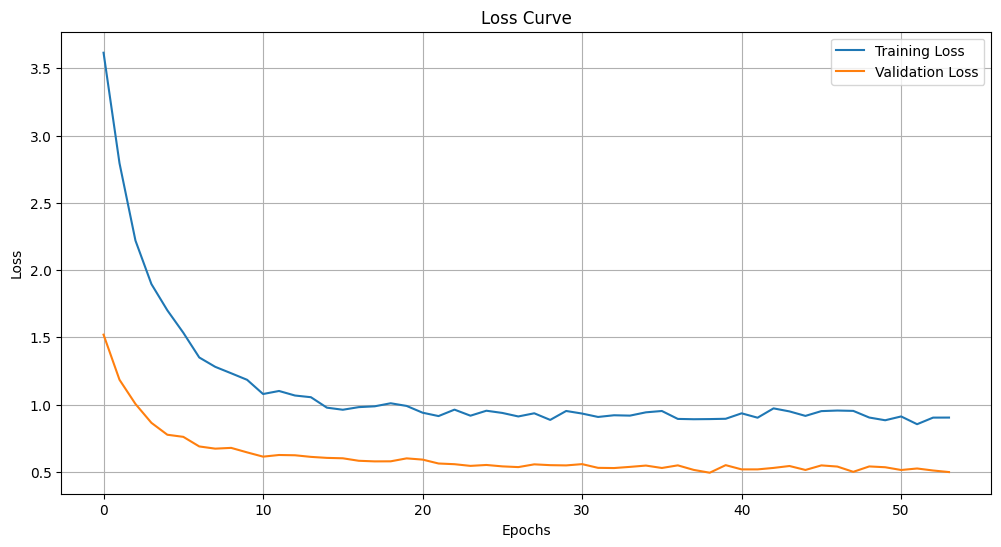

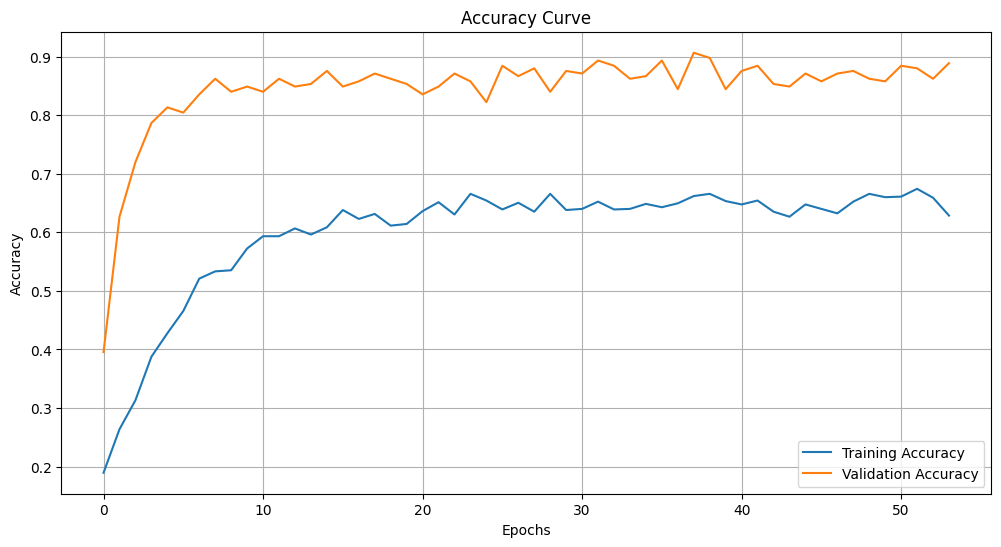

In [10]:
train_loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
train_acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']

import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_pred_densenet = model_densenet.predict(X_test)

# Convert probabilities to class predictions

y_pred_densenet_classes = np.argmax(y_pred_densenet, axis=1)

# True labels
y_true = np.argmax(y_test, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 999ms/step


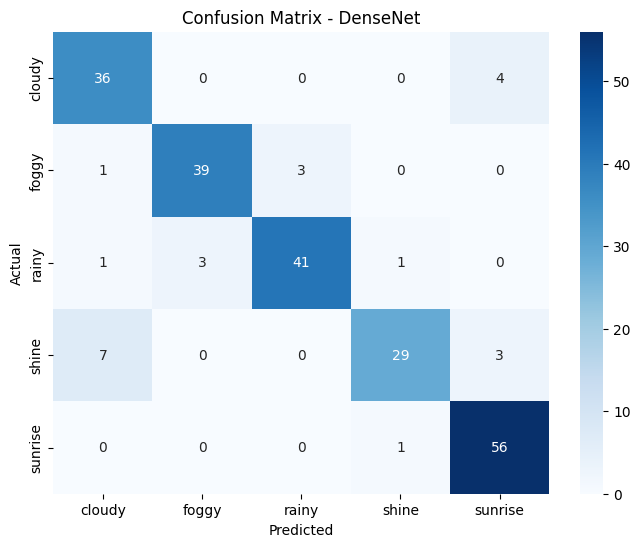

In [12]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Class names
class_names = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

# Plot for DenseNet
plot_confusion_matrix(y_true, y_pred_densenet_classes, class_names, "DenseNet")


In [13]:
# DenseNet metrics
print("DenseNet Classification Report")
print(classification_report(y_true, y_pred_densenet_classes, target_names=class_names))


DenseNet Classification Report
              precision    recall  f1-score   support

      cloudy       0.80      0.90      0.85        40
       foggy       0.93      0.91      0.92        43
       rainy       0.93      0.89      0.91        46
       shine       0.94      0.74      0.83        39
     sunrise       0.89      0.98      0.93        57

    accuracy                           0.89       225
   macro avg       0.90      0.88      0.89       225
weighted avg       0.90      0.89      0.89       225



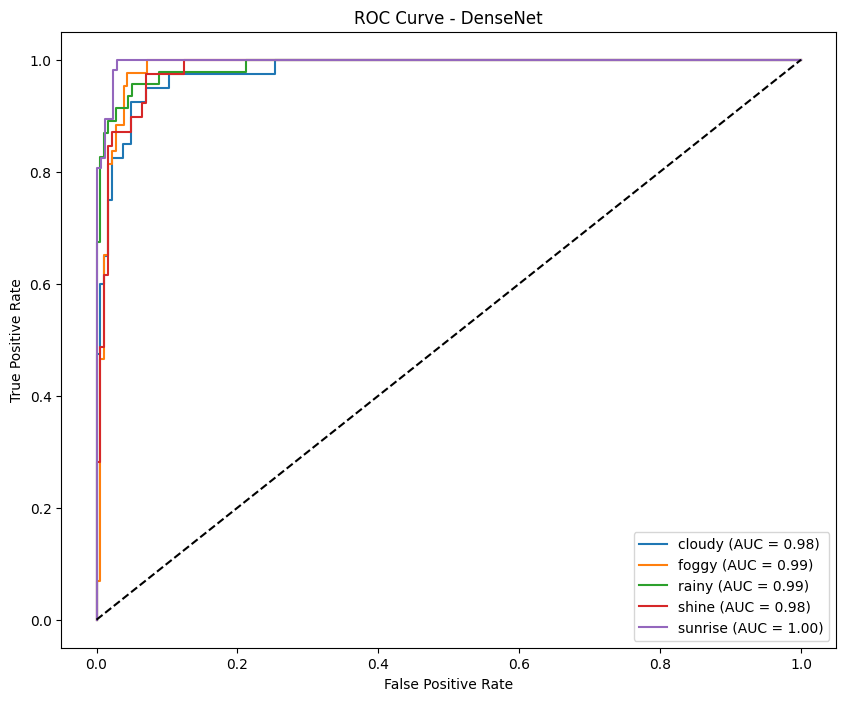

In [14]:
def plot_roc_curve(y_true, y_pred_probs, class_names, model_name):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



# Plot ROC for DenseNet
plot_roc_curve(y_test, y_pred_densenet, class_names, "DenseNet")


In [15]:
# Accuracy for DenseNet
densenet_accuracy = np.mean(y_true == y_pred_densenet_classes)
print(f"DenseNet Accuracy: {densenet_accuracy:.2f}")


DenseNet Accuracy: 0.89


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# DenseNet Metrics
precision_densenet = precision_score(y_true, y_pred_densenet_classes, average='weighted')
recall_densenet = recall_score(y_true, y_pred_densenet_classes, average='weighted')
f1_densenet = f1_score(y_true, y_pred_densenet_classes, average='weighted')

print(f"DenseNet - Precision: {precision_densenet:.2f}, Recall: {recall_densenet:.2f}, F1-Score: {f1_densenet:.2f}")


DenseNet - Precision: 0.90, Recall: 0.89, F1-Score: 0.89
